In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package import StudentModel, TeacherModel
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [3]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 2
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# Load the CIFAR-100 dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    # transforms.Pad((112, 112, 112, 112), padding_mode=‘constant’, fill=0),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(256, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)


Files already downloaded and verified


In [4]:
# Instantiate the models
teacher_model = TeacherModel(in_features=64, num_classes=num_classes)
student_model = StudentModel(in_features=16, num_classes=num_classes)

# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# Knowledge Distillation loss function
def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
    kd_loss = F.kl_div(
        F.log_softmax(student_outputs / temperature, dim=1),
        F.softmax(teacher_outputs / temperature, dim=1),
        reduction='batchmean'
    ) * (temperature * temperature)
    return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Teacher")

# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Student")

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)

# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights.pth')
torch.save(student_model, 'student_model.pth')
print('weights saved and exported')

  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:25, 17.10it/s]

[1, 100] loss: 4.575


 13%|████████████████▊                                                                                                                | 203/1563 [00:12<01:19, 17.11it/s]

[1, 200] loss: 4.497


 19%|█████████████████████████                                                                                                        | 303/1563 [00:18<01:14, 16.85it/s]

[1, 300] loss: 4.409


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:24<01:08, 16.86it/s]

[1, 400] loss: 4.332


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:29<01:01, 17.15it/s]

[1, 500] loss: 4.298


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:35<00:55, 17.16it/s]

[1, 600] loss: 4.220


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:41<00:51, 16.83it/s]

[1, 700] loss: 4.142


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:47<00:45, 16.88it/s]

[1, 800] loss: 4.116


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:53<00:39, 16.81it/s]

[1, 900] loss: 4.071


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:59<00:32, 17.06it/s]

[1, 1000] loss: 4.045


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:05<00:26, 17.15it/s]

[1, 1100] loss: 3.998


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:11<00:21, 16.90it/s]

[1, 1200] loss: 3.953


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:17<00:15, 17.09it/s]

[1, 1300] loss: 3.935


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:22<00:09, 17.07it/s]

[1, 1400] loss: 3.888


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:28<00:03, 17.10it/s]

[1, 1500] loss: 3.875


  7%|████████▌                                                                                                                        | 103/1563 [00:06<01:25, 17.00it/s]

[2, 100] loss: 3.846


 13%|████████████████▊                                                                                                                | 203/1563 [00:12<01:20, 16.96it/s]

[2, 200] loss: 3.853


 19%|█████████████████████████                                                                                                        | 303/1563 [00:18<01:13, 17.03it/s]

[2, 300] loss: 3.808


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:23<01:09, 16.75it/s]

[2, 400] loss: 3.838


 32%|█████████████████████████████████████████▌                                                                                       | 503/1563 [00:29<01:02, 17.07it/s]

[2, 500] loss: 3.784


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:35<00:57, 16.82it/s]

[2, 600] loss: 3.763


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:41<00:51, 16.72it/s]

[2, 700] loss: 3.752


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 803/1563 [00:47<00:45, 16.72it/s]

[2, 800] loss: 3.774


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:53<00:39, 16.53it/s]

[2, 900] loss: 3.785


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:59<00:33, 16.72it/s]

[2, 1000] loss: 3.750


 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1103/1563 [01:05<00:27, 16.94it/s]

[2, 1100] loss: 3.759


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [01:11<00:21, 16.74it/s]

[2, 1200] loss: 3.706


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:17<00:15, 17.04it/s]

[2, 1300] loss: 3.721


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1403/1563 [01:23<00:09, 16.89it/s]

[2, 1400] loss: 3.670


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:29<00:03, 16.86it/s]

[2, 1500] loss: 3.706


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:32<00:00, 16.84it/s]


Finished Training Teacher


  7%|████████▌                                                                                                                        | 103/1563 [00:04<01:07, 21.75it/s]

[1, 100] loss: 1.467


 13%|████████████████▋                                                                                                                | 202/1563 [00:09<01:02, 21.65it/s]

[1, 200] loss: 1.373


 19%|█████████████████████████                                                                                                        | 304/1563 [00:14<00:58, 21.46it/s]

[1, 300] loss: 1.321


 26%|█████████████████████████████████▎                                                                                               | 403/1563 [00:18<00:56, 20.70it/s]

[1, 400] loss: 1.262


 32%|█████████████████████████████████████████▍                                                                                       | 502/1563 [00:23<00:48, 21.78it/s]

[1, 500] loss: 1.172


 39%|█████████████████████████████████████████████████▊                                                                               | 604/1563 [00:28<00:43, 21.84it/s]

[1, 600] loss: 1.107


 45%|██████████████████████████████████████████████████████████                                                                       | 703/1563 [00:32<00:39, 21.81it/s]

[1, 700] loss: 1.019


 51%|██████████████████████████████████████████████████████████████████▏                                                              | 802/1563 [00:37<00:34, 21.97it/s]

[1, 800] loss: 0.930


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 904/1563 [00:42<00:30, 21.86it/s]

[1, 900] loss: 0.842


 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1003/1563 [00:46<00:26, 21.25it/s]

[1, 1000] loss: 0.783


 71%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1102/1563 [00:51<00:21, 21.81it/s]

[1, 1100] loss: 0.711


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1204/1563 [00:55<00:16, 21.66it/s]

[1, 1200] loss: 0.652


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1303/1563 [01:00<00:12, 21.62it/s]

[1, 1300] loss: 0.618


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1402/1563 [01:05<00:07, 21.71it/s]

[1, 1400] loss: 0.588


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1504/1563 [01:09<00:02, 21.75it/s]

[1, 1500] loss: 0.568


  7%|████████▍                                                                                                                        | 102/1563 [00:04<01:07, 21.50it/s]

[2, 100] loss: 0.539


 13%|████████████████▊                                                                                                                | 204/1563 [00:09<01:02, 21.70it/s]

[2, 200] loss: 0.518


 19%|█████████████████████████                                                                                                        | 303/1563 [00:14<00:57, 21.76it/s]

[2, 300] loss: 0.516


 26%|█████████████████████████████████▏                                                                                               | 402/1563 [00:18<00:54, 21.36it/s]

[2, 400] loss: 0.500


 32%|█████████████████████████████████████████▌                                                                                       | 504/1563 [00:23<00:49, 21.44it/s]

[2, 500] loss: 0.499


 39%|█████████████████████████████████████████████████▊                                                                               | 603/1563 [00:28<00:43, 21.84it/s]

[2, 600] loss: 0.491


 45%|█████████████████████████████████████████████████████████▉                                                                       | 702/1563 [00:32<00:40, 21.42it/s]

[2, 700] loss: 0.480


 51%|██████████████████████████████████████████████████████████████████▎                                                              | 804/1563 [00:37<00:35, 21.28it/s]

[2, 800] loss: 0.476


 58%|██████████████████████████████████████████████████████████████████████████▌                                                      | 903/1563 [00:42<00:30, 21.69it/s]

[2, 900] loss: 0.471


 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 1002/1563 [00:46<00:25, 21.60it/s]

[2, 1000] loss: 0.466


 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1104/1563 [00:51<00:21, 21.66it/s]

[2, 1100] loss: 0.462


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1203/1563 [00:56<00:16, 21.69it/s]

[2, 1200] loss: 0.457


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1302/1563 [01:00<00:12, 21.36it/s]

[2, 1300] loss: 0.457


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1404/1563 [01:05<00:07, 21.59it/s]

[2, 1400] loss: 0.449


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1503/1563 [01:09<00:02, 21.81it/s]

[2, 1500] loss: 0.445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.48it/s]

Finished Training Student
weights saved and exported


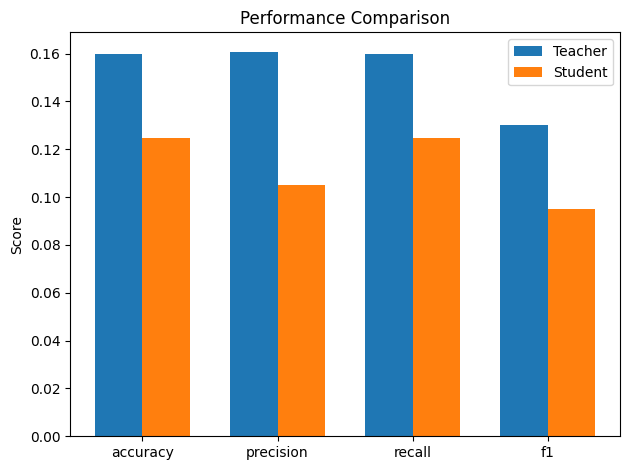

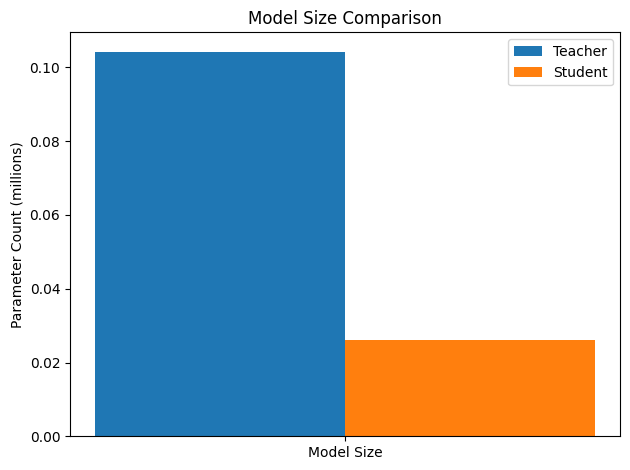

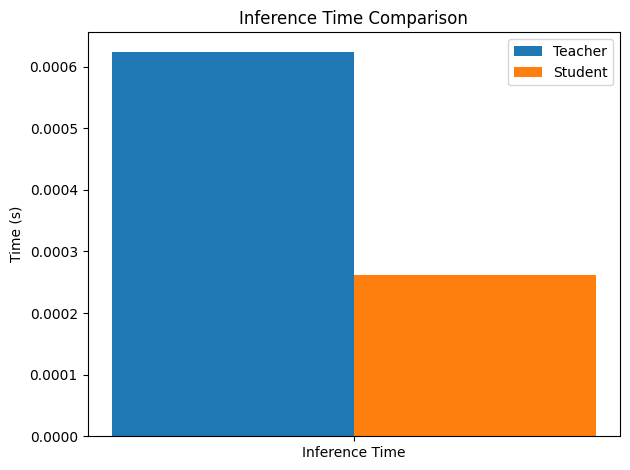

In [5]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')